## IMPORT

In [15]:
from pynq import allocate, Overlay, MMIO
import numpy as np
import csv
import copy 
import time
import struct
import math
from time import perf_counter
from copy import deepcopy
from copy import copy as cp
from pynq import Clocks

In [16]:
import matplotlib.pyplot as plt

In [17]:
%matplotlib notebook

In [18]:
import os
os.getcwd()

'/home/xilinx/jupyter_notebooks/Henk/0221'

## DEFINE

In [19]:
ol = Overlay('design_20240320.bit')
spi = ol.spi
DMA = ol.dma


DMA_send = DMA.sendchannel.transfer
DMA_recv = DMA.recvchannel.transfer
DMA_send_wait = DMA.sendchannel.wait
DMA_recv_wait = DMA.recvchannel.wait

unpack = struct.unpack
pack = struct.pack

# allocate memory for sda IP
DIM = 16
in_buffer = allocate(shape=(DIM,), dtype=np.float32)
out_buffer = allocate(shape=(DIM,), dtype=np.float32)

# Change clock0 frequency
Clocks.fclk0_mhz = 375

#  data transfer in and out sda IP
def run_kernel():
    DMA_send(in_buffer)
    DMA_recv(out_buffer)
    DMA_send_wait()
    DMA_recv_wait()
    return deepcopy(out_buffer)

# convert 2 int16 to float32
def b2f(num_back, num_front):
    return unpack('=f', pack('2H', *[num_back, num_front]))[0]

# convert float32 to 2 int16
def f2b(num):
    return unpack('=2H', pack('f',num))

# bound number in (min, max)
def sat2(num, Max, Min):
    return max(Min, min(num, Max))

## TEST BIT FILE

In [21]:
# estimated states
Tl = 0.000
iqs_est = 0.008
ids_est = 0.008
w_est = 0.001

# real states
w = 0.000
iqs = 0.0
ids = 0.0

# desired state
wd = 10

# others
delta_t = 0.0002
Vq = 0
Vd = 0

R2r = 0.31415926535

SDRE_in = [Tl, iqs_est, ids_est, w_est,\
          w, iqs, ids,\
          wd, delta_t]

in_buffer[:] = [0.0, 0.008, 0.008, 0.008, 0.000, 0.000, 0.000, \
                         0, 0, 0, 0, 0, 0, 10*R2r, 0.0002, 0]

out = run_kernel()
print(out)


# [ 0.0000000e+00  8.0000004e-03  8.0000004e-03  8.0000004e-03
#   3.7355129e+01 -5.4344738e+01 -2.5311810e+01  6.6151543e+00
#   3.0000001e-01  4.2464113e-04  0.0000000e+00  0.0000000e+00
#   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00]

[ 0.0000000e+00  8.0000004e-03  8.0000004e-03  8.0000004e-03
  3.7355129e+01 -5.4344738e+01 -2.5311810e+01  6.6151543e+00
  3.0000001e-01  4.2464113e-04  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00]


In [22]:
in_buffer[:] = np.zeros(16)

In [ ]:
DMA_send = DMA.sendchannel.transfer
DMA_recv = DMA.recvchannel.transfer
DMA_send_wait = DMA.sendchannel.wait
DMA_recv_wait = DMA.recvchannel.wait

for i in range(1000):
    start = time.perf_counter()
    in_buffer[:] = [0.0, 0.008, 0.008, 0.008, 0.000, 0.000, 0.000, \
                         0, 0, 0, 0, 0, 0, 10*R2r, 0.0002, 0]
    DMA_send(in_buffer)
    DMA_recv(out_buffer)
#     DMA_send_wait() # 45us
#     DMA_recv_wait() # 108us
#     output = cp(out_buffer)
    end = time.perf_counter()
    timer = end - start
    print(timer)

In [24]:
%%timeit
DMA_send(in_buffer)
DMA_recv(out_buffer)
DMA_send_wait() # 45us
DMA_recv_wait() # 108us
# outs = deepcopy(out_buffer)

321 µs ± 372 ns per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


## LQR (Python)
#### INPUT : Tl, iqs_est, ids_est, w_est, w, iqs, ids, wd, delta_t, Vq, Vd
#### OUTPUT : Tl, iqs_est, ids_est, w_est, Vq, Vd

In [26]:
# IP: Tl, iqs_est, ids_est, w_est, w, iqs, ids, wd, delta_t, Vq, Vd
# OP: Tl, iqs_est, ids_est, w_est, Vq, Vd

p = 6
Rs = 2.5
Ld = 18e-3 
Lq = 32e-3 
J = 7.82e-4 
B = 0.02277
#     B = 2.51327e-4
Lambdam = 0.30175
#     Lambdam = 0.60646

BASE_VOLTAGE = 236.14

k1=3*p*p/2/J/4*Lambdam
k2=B/J
k3=p/2/J
k4=Rs/Lq
k5=Lambdam/Lq
k6=1/Lq
k7=Rs/Ld
k8=1/Ld
k9=Lq/Ld
k10=Ld/Lq
k11=3*p*p/2/J/4*(Ld-Lq)
k12=(Ld-Lq)/Lambdam

# sda_care
U_obs = [[-83.9371826103988, 54.2990076619623, -2.48337318081849],
         [5025.67992883502, 1707.62556279163, -76.8352318221911],
         [1707.62556279163, 2578.08556925333, 23.1955837522952],
         [-76.8352318221911, 23.1955837522952, 3025.37646717239]]


U_con = [[-30.5662784559950, -120.741847316761, 1.61355293847622],
         [1.76693447765969, 2.86853855729106, -68.3450431051885]]

# N = 0
# U_obs = [[-83.9607235690765, 54.3193970673205, 1.05584373651630e-13],
#          [5023.44325307055, 1708.83223537395, -8.51801553650411e-13],
#          [1708.83223537395, 2577.76814525884, 3.63835774457513e-13],
#          [-8.51801553650411e-13, 3.63835774457513e-13, 3026.43733813050]]

# U_con = [[-30.6354883761756, -120.868778177730, 4.66743359295407e-15],
#          [2.15148037852906e-16, 8.29765972080723e-15, -68.2548584904246]]

R2r = 0.314159265358979


def LQR(IP):
# def LQR(w, iqs, ids, wd):
    
    Tl = IP[0]
    iqs_est = IP[1]
    ids_est = IP[2]
    w_est = IP[3]
    
    Tl_dot = IP[4]
    iqs_est_dot = IP[5]
    ids_est_dot = IP[6]
    w_est_dot = IP[7]
    
    Vq_in = IP[8]
    Vd_in = IP[9]
    
    w = IP[10]
    iqs = IP[11]
    ids = IP[12]
    wd = IP[13]
    
    delta_t = IP[14]


#  ######################### OBSERVER #####################################
   
    Tl += Tl_dot*delta_t
    w_est += w_est_dot*delta_t
    iqs_est += iqs_est_dot*delta_t
    ids_est += ids_est_dot*delta_t
    
    Tl = sat2(Tl, 4.8, -4.8)
    w_est = sat2(w_est, 471.2388980384685, -471.2388980384685)
    iqs_est = sat2(iqs_est, 4.8, -4.8)
    ids_est = sat2(ids_est, 4.8, -4.8)
    
    w_obs = w - w_est
    iqs_obs = iqs - iqs_est
    ids_obs = ids - ids_est
    
    Tl_dot = -83.9371826103988*w_obs + 54.2990076619623*iqs_obs -2.48337318081849*ids_obs
    
    w_est_dot = 5025.67992883502*w_obs + 1707.62556279163*iqs_obs -76.8352318221911*ids_obs \
    + (k1*iqs_est - k2*w_est - k3*Tl + k11*iqs_est*ids_est)
    
    iqs_est_dot = 1707.62556279163*w_obs + 2578.08556925333*iqs_obs + 23.1955837522952*ids_obs \
    + (-k4*iqs_est - k5*w_est + k6*Vq_in - k10*w_est*ids_est)
    
    ids_est_dot = -76.8352318221911*w_obs + 23.1955837522952*iqs_obs + 3025.37646717239*ids_obs \
    + (-k7*ids_est + k9*w_est*iqs_est + k8*Vd_in)
    
    Tle = Tl
    
# ######################### CONTROLLER #####################################   
# [0]: w, [1]: iqs, [2]: ids, [3]: wd

    idsd = k12*iqs*iqs
#     iqsd = (k2*wd + k3*x_est[0] - k11*idsd*IP[5]) / (k1 + k11*(IP[6]-idsd))
    iqsd = (k2*wd + k3*Tle - k11*idsd*iqs) / (k1 + k11*(ids-idsd))
#     iqsd = (k2*wd - k11*idsd*iqs) / (k1 + k11*(ids-idsd))

    w_con =  w - wd
    iq_con = iqs - iqsd
    id_con = ids - idsd

    Vq = -30.5662784559950*w_con - 120.741847316761*iq_con + 1.61355293847622*id_con \
         + (k4*iqsd + k5*wd + k10*id_con*wd + k10*w*idsd)*Lq
    Vd = 1.76693447765969*w_con + 2.86853855729106*iq_con - 68.3450431051885*id_con \
         + (k7*idsd - k9*iq_con*wd - k9*w*iqsd)*Ld
    
    Vq = sat2(Vq, BASE_VOLTAGE*0.3, -BASE_VOLTAGE*0.3) / BASE_VOLTAGE
    Vd = sat2(Vd, BASE_VOLTAGE*0.1, -BASE_VOLTAGE*0.1) / BASE_VOLTAGE
#     OP = list(x_est) + list(Vout)

    return [Tl, iqs_est, ids_est, w_est, Tl_dot, iqs_est_dot, ids_est_dot, w_est_dot, Vq, Vd]
#     return Vq, Vd

In [27]:
# w, iqs, ids, wd
IP = [0.0, 0.008, 0.008, 0.008, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10*R2r, 0.00001]


%timeit LQR(IP)
# print(OP)

43.3 µs ± 28.4 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


## TEST DESIRED SPEED

<IPython.core.display.Javascript object>


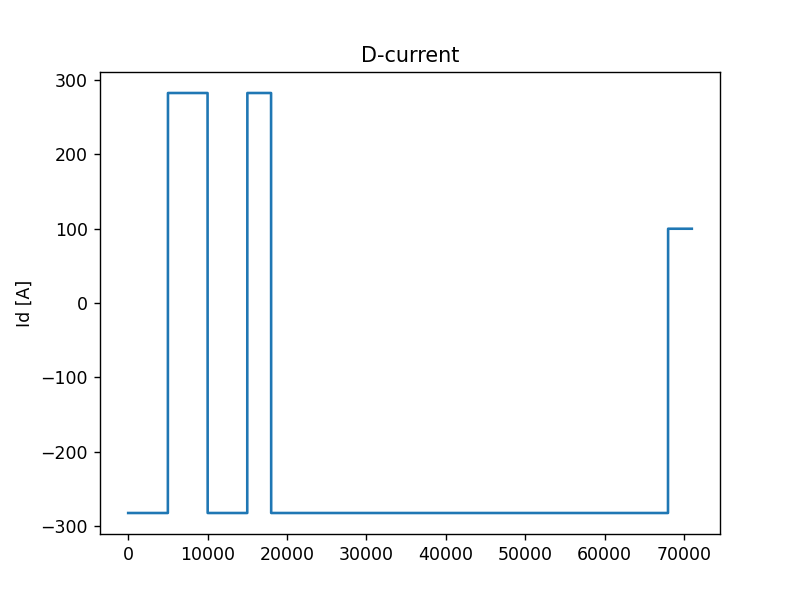

In [28]:
# 1.Hold at wd for hold_step steps 2.Save in Wd.
def HOLD(wd, hold_step, Wd):
    for i in range(hold_step):
        Wd.append(wd)
        
    return Wd

# 1.Change from wd to w_target. 2.Increase/decrease increment per step. 3.Save in Wd.
def CHANGE(wd, w_target, increment, Wd):
    while abs(w_target - wd) >= increment:
        if w_target > wd:
            wd = wd + increment
        else:
            wd = wd - increment

        Wd.append(wd)
    
    return Wd


Wd = []
target_RPM = 900
target_rad = target_RPM*math.pi/10

hold_step = 3000
increment = 0.1512

# Wd = CHANGE(3.1415926, -target_rad, increment/2, Wd)
Wd = HOLD(-target_rad, 5000, Wd)

# Wd = CHANGE(Wd[-1], target_rad, increment, Wd)
Wd = HOLD(target_rad, 5000, Wd)

# Wd = CHANGE(Wd[-1], -target_rad, increment, Wd)
Wd = HOLD(-target_rad, 5000, Wd)

# Wd = CHANGE(Wd[-1], target_rad, increment, Wd)
Wd = HOLD(target_rad, hold_step, Wd)

# Wd = CHANGE(Wd[-1], -target_rad, increment, Wd)
Wd = HOLD(-target_rad, 50000, Wd)

# Wd = CHANGE(Wd[-1], 100, increment, Wd)
Wd = HOLD(100, hold_step, Wd)


plt.figure(6)
plt.plot(Wd)
# plt.ylim(3.3,3.335)
plt.title('D-current')
plt.ylabel('Id [A]')
plt.show()


# SDRE

In [ ]:
DMA_send = DMA.sendchannel.transfer
DMA_recv = DMA.recvchannel.transfer
DMA_send_wait = DMA.sendchannel.wait
DMA_recv_wait = DMA.recvchannel.wait

unpack = struct.unpack
pack = struct.pack

SPI_write = spi.write
SPI_read = spi.read

# spi initialization
def spi_inits():
    SPI_write(0x40, 0x0a)     # reset core
    SPI_write(0x60, 0x166)
    SPI_write(0x1c, 0x1)      # Global Interrupt Enabled
    SPI_write(0x70, 0x0)
    SPI_write(0x60, 0x66)
    
def F2H(f):
    return unpack('=I', pack('=f', f))[0]

def I2F(i32):
    return unpack("=f", pack("=I", i32))[0]

# 1.Hold at wd for hold_step steps 2.Save in Wd.
def HOLD(wd, hold_step, Wd):
    for i in range(hold_step):
        Wd.append(wd)
        
    return Wd

# 1.Change from wd to w_target. 2.Increase/decrease increment per step. 3.Save in Wd.
def CHANGE(wd, w_target, increment, Wd):
    while abs(w_target - wd) >= increment:
        if w_target > wd:
            wd = wd + increment
        else:
            wd = wd - increment

        Wd.append(wd)
    
    return Wd

# allocate memory for sda IP
DIM = 16
in_buffer = allocate(shape=(DIM,), dtype=np.float32)
out_buffer = allocate(shape=(DIM,), dtype=np.float32)

reg_write = 0x68
reg_read = 0x6C

# estimated states
Tl = 0.000
iqs_est = 0.008
ids_est = 0.008
w_est = 0.001

TL_dot = 0.000
iqs_est_dot = 0.000
ids_est_dot = 0.000
w_est_dot = 0.000

# others
Vq = 0
Vd = 0
delta_t = 0.00001

# real states
w = 0.000
iqs = 0.0
ids = 0.0

IP = [0, 0, 0, 0]
OP = [0, 0]

data1 = 0
data2 = 0
data3 = 0
data4 = 0
data5 = 0
data6 = 0

BASE_VOLTAGE = 236.14
BASE_CURRENT = 10.0
BASE_TORQUE = 4.8

I_lim = 1.5*BASE_CURRENT
T_lim = 1.5*BASE_TORQUE
W_lim = 1000
V_lim = BASE_VOLTAGE

Vq = 0
Vd = 0

data = []
W = []
IQS = []
IDS = []
TIME = []
OUT = []
elapse = 0
# dout = [[0,0],[0,0]]
dout = [0,0]
i = 0


# /////////////// desired state ///////////////////////

Wd = []
target_RPM = 900
target_rad = target_RPM*math.pi/10

hold_step = 5000
increment = 0.1512

# Wd = CHANGE(3.1415926, -target_rad, increment/2, Wd)
Wd = HOLD(-target_rad, hold_step, Wd)

# Wd = CHANGE(Wd[-1], target_rad, increment, Wd)
Wd = HOLD(target_rad, hold_step, Wd)

# Wd = CHANGE(Wd[-1], -target_rad, increment, Wd)
Wd = HOLD(-target_rad, hold_step, Wd)

# Wd = CHANGE(Wd[-1], target_rad, increment, Wd)
Wd = HOLD(target_rad, 1500, Wd)

# Wd = CHANGE(Wd[-1], -target_rad, increment, Wd)
Wd = HOLD(-target_rad, 50000, Wd)

# Wd = CHANGE(Wd[-1], 100, increment, Wd)
Wd = HOLD(100, hold_step, Wd)
    
Wd_length = len(Wd)-1

# /////////////////////////////////////////////////////
    
LQR_in =  [Tl, iqs_est, ids_est, w_est, TL_dot, iqs_est_dot, ids_est_dot, w_est_dot, Vq, Vd, \
            w, iqs, ids, Wd[0], delta_t, 0]

LQR_out = [Tl, iqs_est, ids_est, w_est, TL_dot, iqs_est_dot, ids_est_dot, w_est_dot, Vq, Vd, \
            w, iqs, ids, Wd[0], delta_t, 0]    

SDRE_in =  [Tl, iqs_est, ids_est, w_est, TL_dot, iqs_est_dot, ids_est_dot, w_est_dot, Vq, Vd, \
            w, iqs, ids, Wd[0], delta_t, 0]

SDRE_out = [Tl, iqs_est, ids_est, w_est, TL_dot, iqs_est_dot, ids_est_dot, w_est_dot, Vq, Vd, \
            0, 0, 0, 0, 0, 0]    
    
spi_inits()

print("START MAIN!!")

# run SDRE, stop when KeyboardInterrupt
try:
    time.sleep(5)
    
    while 1:
        start = perf_counter()

        SPI_write(reg_write, F2H(SDRE_out[8]))
        SPI_write(reg_write, F2H(SDRE_out[9]))
        SPI_write(reg_write, 0)

        # recieve w, iqs, ids from F28335
        data1 = SPI_read(reg_read)
        data2 = SPI_read(reg_read)
        data3 = SPI_read(reg_read)

# use when transfer with 32 bits
        w = I2F(data1)
        iqs = I2F(data2)
        ids = I2F(data3)
        
# # ====================================== SDRE part ============================================          
# INPUT:  Tl, iqs_est, ids_est, w_est, TL_dot, iqs_est_dot, ids_est_dot, w_est_dot, Vq, Vd, w, iqs, ids, wd, delta_t
# OUTPUT: Tl, iqs_est, ids_est, w_est, TL_dot, iqs_est_dot, ids_est_dot, w_est_dot, Vq, Vd
# # =============================================================================================

        in_buffer[:15] = list(SDRE_out[:10]) + [w, iqs, ids, Wd[i], delta_t]

        DMA_send(in_buffer)
        DMA_recv(out_buffer)
#         DMA_send_wait()
#         DMA_recv_wait()
        
#         SDRE_out = deepcopy(out_buffer)
        
        SDRE_out = out_buffer
        
# # =============================================================================================

        if i < Wd_length:
            i = i + 1
        else:
            SDRE_out[8] = 0.03
            SDRE_out[9] = 0.01
            

# ======================================= RECORD DATA ====================================
        W.append(w)
        IQS.append(iqs)
        IDS.append(ids)

        end = perf_counter()
        TIME.append(end-start)

# ========================================================================================   

except KeyboardInterrupt:
    while(SPI_read(0x78) != 0):
        release = SPI_read(0x6C)
        print(release)
        
    print("Finished")

In [69]:
Time = []
w = []
iqs = []
ids = []
RT = 0
Real_Time = []

for d in TIME:
    Time.append(d)
    Real_Time.append(RT)
    RT = d + RT

<IPython.core.display.Javascript object>


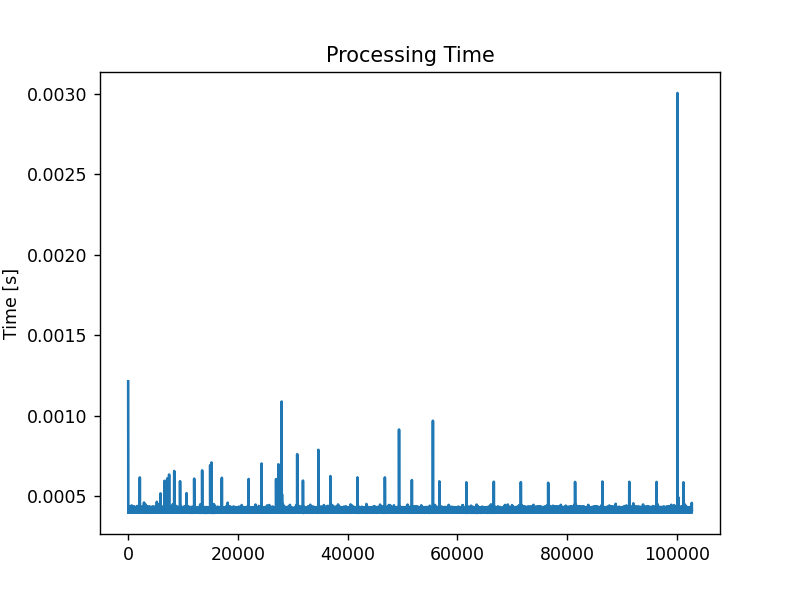

In [71]:
plt.figure(1)
plt.plot(Time)
plt.title('Processing Time')
plt.ylabel('Time [s]')
plt.show()

In [72]:
mean = np.mean(Time)
print(mean)

c = 0
for i in Time:
    if i > 0.0005:
        c = c + 1
        
print(c)
print("Lost: {:.5f}%".format(c/len(Time)*100))

0.0004014801491181542
59
Lost: 0.05743%


<IPython.core.display.Javascript object>


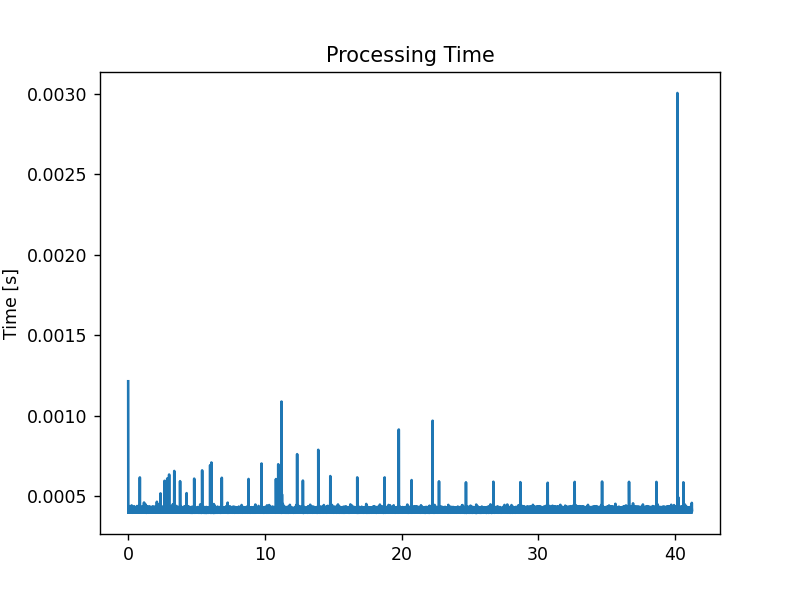

In [73]:
plt.figure(2)
plt.plot(Real_Time, Time)
plt.title('Processing Time')
plt.ylabel('Time [s]')
plt.show()

<IPython.core.display.Javascript object>


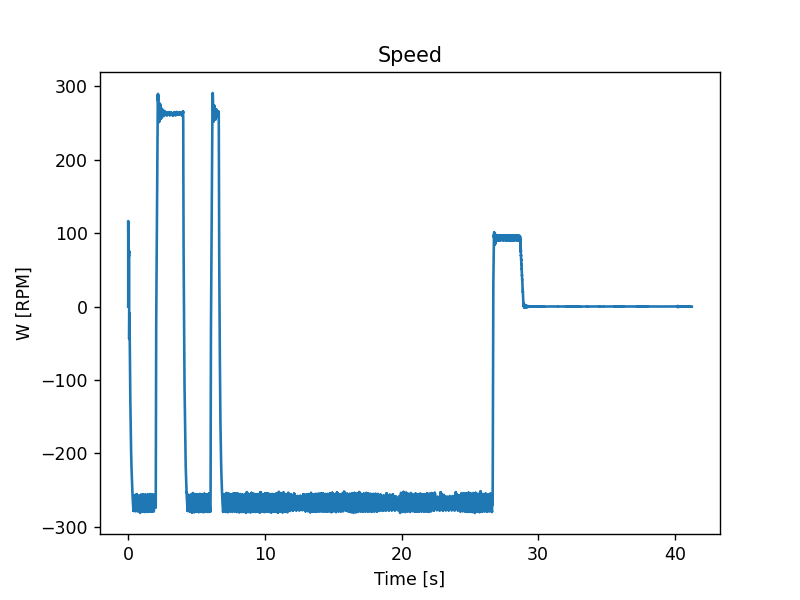

In [74]:
plt.figure(3)
plt.plot(Real_Time, W)
plt.title('Speed')
plt.ylabel('W [RPM]')
plt.xlabel('Time [s]')
plt.show()

In [75]:
np.mean(W)

-132.81181346189558

<IPython.core.display.Javascript object>


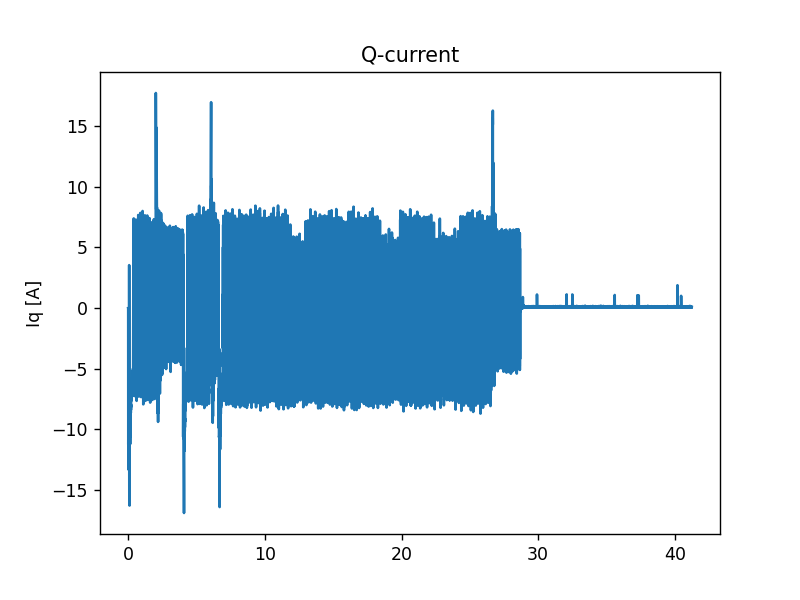

In [76]:
plt.figure(4)
plt.plot(Real_Time, IQS)
plt.title('Q-current')
plt.ylabel('Iq [A]')
plt.show()

In [77]:
np.mean(IQS)

-2.2194335916442993

<IPython.core.display.Javascript object>


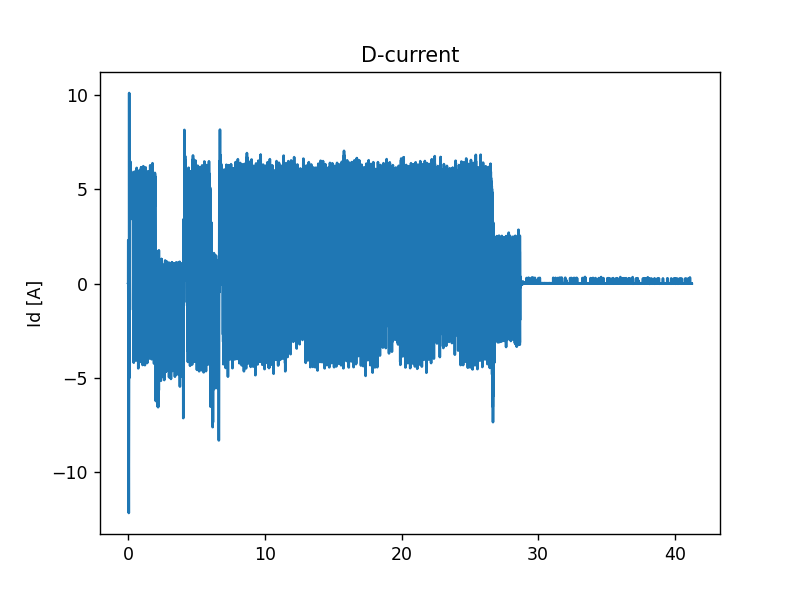

In [78]:
plt.figure(5)
plt.plot(Real_Time, IDS)
plt.title('D-current')
plt.ylabel('Id [A]')
plt.show()

In [79]:
np.mean(IDS)

1.9786059305146515

## OUTPUT DATA TO CSV

In [81]:
# DATA OUTPUT TO CSV

data = []
for i in range(len(TIME)):
    data.append([W[i], IQS[i], IDS[i], TIME[i]])

file_name = input("Enter file name: ") + '.csv'

with open(file_name, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    for d in data:
        writer.writerow(d)

Enter file name: SDRE_20240606-17
